In [1]:
import torch
import torchvision  
import torch.nn.functional as F  

from torch import optim 
from torch import nn  
from torch.utils.data import DataLoader 

from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
import utils

from torchsummary import summary

C:\Users\mati\anaconda3\envs\pytorch_2022\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [34]:
batch_size = 64
input_size = 28*28
lstm_hidden_size = 64
num_classes = 2
learning_rate = 0.001
num_epochs = 1
num_lstm_layers = 2

## Load data

In [47]:
custom_train_loader = utils.MnistSequences()
custom_test_loader = utils.MnistSequences(train=False)

In [48]:
custom_train_loader.reset()
custom_test_loader.reset()

train_loader = DataLoader(dataset=custom_train_loader, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=custom_test_loader, batch_size=64, shuffle=True)

## Visualize data

label: tensor(1)


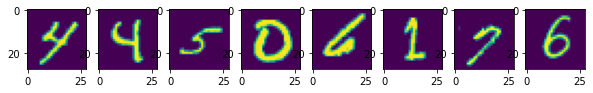

In [7]:
(x, y) = next(iter(train_loader))

columns = len(x[0])
rows = 1
fig = plt.figure(figsize=(10, 10))

for idx in range(1*columns):
    
    image = x[0][idx]
    fig.add_subplot(rows, columns, idx+1)
    plt.imshow(image)
    
print("label:", y[0])

## Model

In [44]:
# Recurrent neural network with LSTM (many-to-one)
class LSTM_Model(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, num_lstm_layers, num_classes):
        super(LSTM_Model, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.num_lstm_layers = num_lstm_layers
        
        self.conv1 = nn.Conv2d(1,16,3)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(64*3*3, 128)
        
        self.lstm = nn.LSTM(128, lstm_hidden_size, num_lstm_layers, batch_first=True)
        self.fc2 = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        
        # Declare c0 and h0 hidden states for start lstm sequence
        c0 = torch.zeros(self.num_lstm_layers, x.size(0), self.lstm_hidden_size).to(device)
        h0 = torch.zeros(self.num_lstm_layers, x.size(0), self.lstm_hidden_size).to(device)
        
        batch_size, timesteps, H, W = x.size()
        x = x.view(batch_size*timesteps,1,H,W)
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        
        x = x.view(batch_size*timesteps,-1)
        
        x = F.relu(self.fc1(x))
        
        x = x.view(batch_size,timesteps,-1)

        x, _ = self.lstm(x, (h0, c0)) 

        x = x[:, -1, :]
        x = x.reshape(x.shape[0], -1)

        x = self.fc2(x)
        return x



In [45]:
model = LSTM_Model(input_size, lstm_hidden_size, num_lstm_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [46]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            73,856
├─LSTM: 1-6                              82,944
├─Linear: 1-7                            130
Total params: 180,226
Trainable params: 180,226
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            73,856
├─LSTM: 1-6                              82,944
├─Linear: 1-7                            130
Total params: 180,226
Trainable params: 180,226
Non-trainable params: 0

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (x_data, y_data) in enumerate(tqdm(train_loader)):

        x_data = x_data.to(device=device).squeeze(1)
        y_data = y_data.to(device=device)

        # forward
        outputs = model(x_data)
        loss = criterion(outputs, y_data)

        # backward
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()


## Test

In [43]:
def check_accuracy(data_loader, model):
    
    N = 0
    num_correct = 0
    
    # Set model to evaluate state
    model.eval()

    with torch.no_grad():
        for x_data, y_data in data_loader:
            
            x_data = x_data.to(device=device).squeeze(1)
            y_data = y_data.to(device=device)

            predictions = model(x_data)
            _, predictions = predictions.max(1)
            num_correct += (predictions == y_data).sum()
            N += predictions.size(0)

            print("Accuracy", 100. * num_correct / N)


check_accuracy(test_loader, model)

Accuracy tensor(100.)
Accuracy tensor(98.4375)
Accuracy tensor(98.9583)
Accuracy tensor(98.8281)
Accuracy tensor(99.0625)
Accuracy tensor(98.6979)
Accuracy tensor(98.8839)
Accuracy tensor(99.0234)
Accuracy tensor(98.6111)
Accuracy tensor(98.7500)
Accuracy tensor(98.8636)
Accuracy tensor(98.9583)
Accuracy tensor(99.0385)
Accuracy tensor(98.8839)
Accuracy tensor(98.8542)
Accuracy tensor(98.8281)
Accuracy tensor(98.8971)
Accuracy tensor(98.8715)
Accuracy tensor(98.8487)
Accuracy tensor(98.9062)
Accuracy tensor(98.9583)
Accuracy tensor(99.0057)
Accuracy tensor(99.0489)
Accuracy tensor(99.0234)
Accuracy tensor(99.)
Accuracy tensor(99.0385)
Accuracy tensor(99.0741)
Accuracy tensor(99.1071)
Accuracy tensor(99.0841)
Accuracy tensor(99.0625)
Accuracy tensor(99.0927)
Accuracy tensor(99.0234)
Accuracy tensor(99.0530)
Accuracy tensor(99.0349)
Accuracy tensor(99.0179)
Accuracy tensor(99.0017)
Accuracy tensor(98.9865)
Accuracy tensor(99.0132)
Accuracy tensor(98.9183)
Accuracy tensor(98.9062)
Accurac